# Ridge Regression using SciKit-Learn
----   

## Regularization in 5 minutes
Before we get started with the code in this module, let's go through quickly go through the theory behind regularization.   

If you covered the previous module on [Linear Regression](https://www.youtube.com/watch?v=cSKzqb0EKS0), you will remember that we performed manual variable selection to improve the predictive accuracy of our model. This process of variable selection is discrete in that we will either keep a variable, or we will throw it away.   

Regularization offers an alternative method in which all predictor variables are included, but are subject to constraint. You will (hopefully) remember from the previous module that the least squares method seeks to minimise the sum of the squares of the residuals.

$$RSS = \sum_{i=1}^n(y_i-\hat{y}_i)^2$$   

which can be written in terms of the predictor variable coefficients, [$b_1, b_2, b_p$], and slope, $a$:   

$$RSS = \sum_{i=1}^n(y_i-(a+\sum_{j=1}^pb_jx_{ij}))^2$$   


In the case of ridge regression, the regression coefficients are calculated as the values that minimise:   
$$\sum_{i=1}^n(y_i-(a+\sum_{j=1}^pb_jx_{ij}))^2 + \alpha\sum_{j=1}^pb_j^2$$   
which is just simply:
$$RSS + \alpha\sum_{j=1}^pb_j^2$$   

$\alpha$ above is a tuning parameter (which we'll need to determine - more on this later) which affects how much the regression coefficients are penalised. The effect of this penalty parameter is that it creates a tradeoff between a coefficient's contribution to minimizing RSS and its size, i.e. **training fit** vs **size of coefficients**.   

Looking at the equation above, we can see that the penalty parameter is applied to the sum of the squares of the coefficients. So naturally, as we increase the size of the coefficients, the penalty will increase too. And so, this has the effect of *shrinking* the coefficients towards zero.   
![tradeoff](./images/tradeoff.png)

So, with all of that in mind, let's do some Ridge Regression and find out if we can improve our results.

## Getting started
To begin, as usual, we will need to import a few Python libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Next** we will load our data as a Pandas DataFrame.

In [2]:
df = pd.read_csv('data_2.csv', index_col=0)
df.head()

,ZAR/USD,Value of Exports (USD),Value of Exports (ZAR),Value of Imports (USD),Value of Imports (ZAR),Total Reserves excl Gold (USD),IMF Reserve Position (USD),Foreign Exchange (USD),Claims on Non-residents (USD),Liabilities to Non-residents (USD),Central Bank Policy Rate,Money Market Rate,Treasury Bill Rate,Savings Rate,Deposit Rate,Lending Rate,Government Bonds,"Financial Market Prices, Equities Index",Producer Price Index,Consumer Price Index
2008M01,7.01,5611.90,39356.82,8105.11,56841.94,29884.51,1.92,29526.78,51547.61,37752.29,11.0,10.64,10.47,4.53,10.83,14.5,8.36,312.97,86.03,85.48
2008M02,7.66,6126.16,46946.33,8159.43,62527.78,30304.31,2.01,29943.04,59702.31,45927.67,11.0,10.66,10.32,5.61,11.00,14.5,8.69,335.09,87.23,85.91
2008M03,7.97,6417.48,51150.89,8010.87,63851.12,30615.42,2.05,30246.54,56448.18,42565.17,11.0,10.69,10.18,5.62,11.04,14.5,9.16,348.84,89.00,87.04
2008M04,7.79,7215.71,56174.34,9112.97,70944.49,30763.42,2.03,30399.21,55534.75,43342.70,11.5,11.00,10.27,5.80,11.28,15.0,9.15,358.47,90.83,87.61
2008M05,7.62,7379.67,56240.45,9090.14,69275.97,30831.43,2.10,30467.81,57682.89,46533.13,11.5,11.20,10.60,6.50,11.39,15.0,9.51,371.98,95.32,88.32


In [3]:
df.shape

(120, 20)

We will be using a dataset which contains monthly data for the Rand/Dollar exchange rate, as well as a few potential predictor variables. In this case, the goal is to try and model the exchange rate, using the other 19 variables.   

Here our model is:   

$$Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_pX_p$$   

In this case, $Y$ is the reponse variable which depends on the $p$ predictor variables.

## Preprocessing
We can see in the data above that the variables have different scales. For example, we have many variables which are monetary and have values in the tens of the thousands; whereas other variables are rates which are on a percentage scale.   

Regularization puts constraints on the size of the coefficients related to each variable. Rescaling is very important for methods with regularization because the size of the variables affects how much regularization (size of penalty) will be applied to that specific variable. So to make it fair, we need to get all the features on the same scale.

If you apply [0,1] normalization you are essentially squeezing your data into the range [0,1]. This will mean that if there are outliers, the bulk of your data will all lie in a small range, so you would lose information. Z-score normalization (standardization), on the other hand, does not suffer from this drawback as the range will just be larger. Therefore we will standardize the features.

Sklearn makes rescaling easy. We'll import the `StandardScalar()` object from `sklearn.preprocessing`.

In [4]:
X = df.drop('ZAR/USD', axis=1)
y = df['ZAR/USD']

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
scaler = StandardScaler()

In [7]:
X_scaled = scaler.fit_transform(X)

In [8]:
X_standardize = pd.DataFrame(X_scaled,columns=X.columns)
X_standardize.head()

,Value of Exports (USD),Value of Exports (ZAR),Value of Imports (USD),Value of Imports (ZAR),Total Reserves excl Gold (USD),IMF Reserve Position (USD),Foreign Exchange (USD),Claims on Non-residents (USD),Liabilities to Non-residents (USD),Central Bank Policy Rate,Money Market Rate,Treasury Bill Rate,Savings Rate,Deposit Rate,Lending Rate,Government Bonds,"Financial Market Prices, Equities Index",Producer Price Index,Consumer Price Index
0,-1.341230,-1.820002,0.205077,-1.124305,-2.145276,-0.740237,-2.040128,0.325086,-0.356166,2.195535,2.098427,2.225653,0.692028,2.036107,2.195535,-0.234691,2.625151,-1.613707,-1.690995
1,-0.934909,-1.404295,0.248319,-0.821735,-2.057421,-0.739864,-1.936778,2.106157,1.670410,2.195535,2.108767,2.136289,1.529205,2.124739,2.195535,0.294266,2.985518,-1.567326,-1.667091
2,-0.704734,-1.173995,0.130057,-0.751314,-1.992313,-0.739698,-1.861424,1.395422,0.836888,2.195535,2.124275,2.052883,1.536956,2.145593,2.195535,1.047628,3.209525,-1.498915,-1.604276
3,-0.074046,-0.898842,1.007391,-0.373843,-1.961339,-0.739781,-1.823519,1.195919,1.029628,2.452574,2.284533,2.106501,1.676486,2.270721,2.452574,1.031600,3.366412,-1.428184,-1.572591
4,0.055500,-0.895220,0.989217,-0.462633,-1.947106,-0.739490,-1.806486,1.665095,1.820496,2.452574,2.387925,2.303101,2.219101,2.328071,2.452574,1.608643,3.586510,-1.254644,-1.533123


Taking a look at one of the variables as an example, we can see that standarizing the data has caused it to be centered around zero.

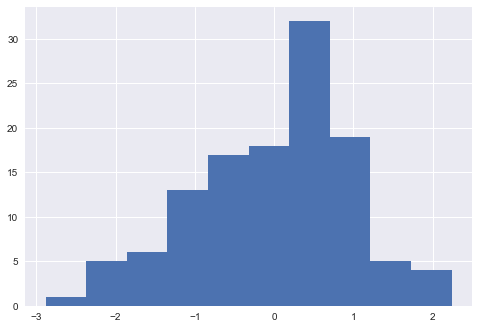

In [9]:
plt.hist(X_standardize['Value of Exports (USD)'])
plt.show()

Furthermore, the variance within each variable in the data is now equal to one. 

In [10]:
X_standardize.describe().loc['std']

Value of Exports (USD)                     1.004193
Value of Exports (ZAR)                     1.004193
Value of Imports (USD)                     1.004193
Value of Imports (ZAR)                     1.004193
Total Reserves excl Gold (USD)             1.004193
IMF Reserve Position (USD)                 1.004193
Foreign Exchange (USD)                     1.004193
Claims on Non-residents (USD)              1.004193
Liabilities to Non-residents (USD)         1.004193
Central Bank Policy Rate                   1.004193
Money Market Rate                          1.004193
Treasury Bill Rate                         1.004193
Savings Rate                               1.004193
Deposit Rate                               1.004193
Lending Rate                               1.004193
Government Bonds                           1.004193
Financial Market Prices, Equities Index    1.004193
Producer Price Index                       1.004193
Consumer Price Index                       1.004193
Name: std, d

## Ridge Regression
We will first split our data into a training and a testing set. We'll use the first 8 years of data as our training set and test the model on the final two years.  

Fitting and testing a Ridge Regression model is very similar to multiple variable regression in sk-learn. For now, we are going to create a `Ridge()` object without modifying any of the parameters. This means that we will use the default value of $\alpha=1$. In a later tutorial, we'll learn about choosing a better value of this hyperparameter.

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_standardize, 
                                                    y, 
                                                    test_size=0.2, 
                                                    shuffle=False)

In [13]:
from sklearn.linear_model import Ridge

In [14]:
ridge = Ridge()

In [15]:
ridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [16]:
b = float(ridge.intercept_)

In [17]:
coeff = pd.DataFrame(ridge.coef_, X.columns, columns=['Coefficient'])

In [18]:
print("Intercept:", float(b))

Intercept: 10.1268900700632


In [19]:
coeff

,Coefficient
Value of Exports (USD),-0.542478
Value of Exports (ZAR),0.973215
Value of Imports (USD),-0.711990
Value of Imports (ZAR),0.957165
Total Reserves excl Gold (USD),0.012201
IMF Reserve Position (USD),0.036197
Foreign Exchange (USD),0.120280
Claims on Non-residents (USD),0.069619
Liabilities to Non-residents (USD),0.003063
Central Bank Policy Rate,0.189549


### Interpretation of the intercept and coefficients
Because we standardized the features, we interpret the intercept slightly differently than in the case of multiple variable linear regression. Previously it was the expected Dollar/Rand exchange rate when all feature values are set to zero. Now, since the standardized features are all centered around zero, the intercept can be interpreted as the expected exchange rate when all the features are equal to their means.   

As with the intercept, the coefficients also have a different interpretation. Previously (without standardization) it was the expected change in exchange rate given an increase of 1 unit in the feature value. Now (with standardization) it is the expected change in exchange rate given an increase of 1 in the **scaled feature value**.

The advantage here is that it becomes easier to compare coefficients to eachother, since their respective variables are all on the same scale. Now, variables with smaller coefficients are less important - they have suffered more in the shrinkage tradeoff.

## Assessment of predictive accuracy
We can make use of the `sklearn.metrics` library to assess the accuracy of our model. For comparison, we'll quickly fit a linear model (without regularization) to the data.

In [20]:
# fit a basic linear model
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [21]:
from sklearn import metrics

In [22]:
# check training accuracy
train_lm = lm.predict(X_train)
train_ridge = ridge.predict(X_train)

print('Training MSE')
print('Linear:', metrics.mean_squared_error(y_train, train_lm))
print('Ridge :', metrics.mean_squared_error(y_train, train_ridge))

Training MSE
Linear: 0.0326535702136
Ridge : 0.0396961380982


In [23]:
test_lm = lm.predict(X_test)
test_ridge = ridge.predict(X_test)

print('Testing MSE')
print('Linear:', metrics.mean_squared_error(y_test, test_lm))
print('Ridge :', metrics.mean_squared_error(y_test, test_ridge))

Testing MSE
Linear: 1.68360120988
Ridge : 0.669185689818


### Comment:
From the results above, we can see that Ridge regression achieves a much lower score on the testing set at the expense of a slightly higher score on the training set. The increase in training MSE is not anything to be worried about since we want to avoid overfitting on the training set.   

As a final step, let's plot our results.

In [24]:
# we want to plot the train and test response variables as a continuous line
train_plot = y_train.append(pd.Series(y_test[0], index=['2016M01']))

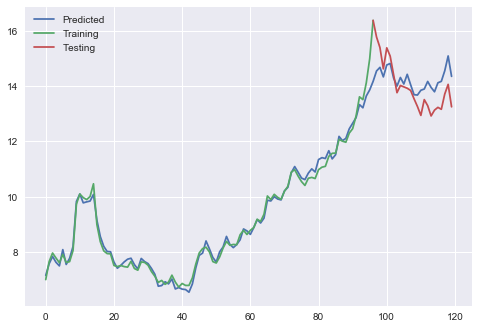

In [25]:
plt.plot(np.arange(len(y)), ridge.predict(X_standardize), label='Predicted')
plt.plot(np.arange(len(train_plot)), train_plot, label='Training')
plt.plot(np.arange(len(y_test))+len(y_train), y_test, label='Testing')
plt.legend()

plt.show()